## 1. Importando módulos e funções
    Por: Rodolpho C. Braga (RCB)                  02 de Novembro de 2018.
         
    

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
sys.path.append("../../")
from rdkit_ipynb_tools import tools
from rdkit_ipynb_tools import  pipeline as p
from rdkit_ipynb_tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

#Modeling tools
exec(open('../../rdkit_ipynb_tools/modeling.py').read())

#Alerts Single rule pattern

#Alerts multicategory
# exec(open('../../rdkit_ipynb_tools/alerts.py').read())

#Alerts Cross Rules (complex)

  * could not import Bokeh, plotting with Highcharts instead.
- no local installation of highcharts found, using web version.
- loading highcharts...


* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
rdkit_ipynb_tools.tools                       (171025-07:16)
- no local installation of JSME found, using web version.
* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
> interactive IPython session.
rdkit_ipynb_tools.sar                         (180320-16:59)


Using TensorFlow backend.


## 2. Entrada dos dados

Escolher a formda da entrada dos dados:
1. SDF
1. CSV

### 2.1 SDF

In [2]:
#Caminho do SDF
file= "data/AI_balanced.sdf"

sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
print(moldf.shape)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
#logP
moldf['logP'] = moldf['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
print(moldf.shape)
#Colunas no pandas
moldf.keys()

(2291, 11)
(2291, 12)


Index(['CASRN', 'CpId', 'ID', 'InChIKey', 'Index', 'Outcome', 'Mol', 'SMILES', 'StandardizerResult', 'UN GHS', 'knn Distance', 'logP'], dtype='object')

### 2.2 CSV compactado para GZ

Os dados devem estar compactados para GZ (Reduz 90% do tamanho do arquivo).<br>
Você vai precisar:
1. Windows usar o 7-ZIP para compactar
1. Linux: gzip nomedoarquivo.csv
1. Em geral o encoding utf-8 funciona na maioria dos casos. Se nã uncionar usar o utf-16.

### 3. Definir a coluna a ser usada como variável dependente

In [3]:
moldf = moldf.rename(columns={'Outcome': 'Outcome'})

,CASRN,CpId,ID,InChIKey,Index,Outcome,Mol,SMILES,StandardizerResult,UN GHS,knn Distance,logP
0,553-86-6,1,1,ACZGCWSMSTYWDQ-UHFFFAOYSA-N,1,1,,O=C1Cc2ccccc2O1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),2A,,1.1481

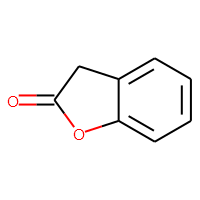

In [4]:
moldf.head(1)

,CASRN,CpId,ID,InChIKey,Index,Outcome,Mol,SMILES,StandardizerResult,UN GHS,knn Distance,logP,RowID
1146,95-49-8,296,296,IBSQPLPBRSHTTG-UHFFFAOYSA-N,296,0,,Cc1ccccc1Cl,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,1.41421353816986,2.64842,1146
1537,15687-27-1,1647,1647,"InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)",1647,0,,CC(C)Cc1ccc(C(C)C(=O)O)cc1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),NaN,3.0,3.07320,1537
1536,625-69-4,1601,1601,"InChI=1S/C5H12O2/c1-4(6)3-5(2)7/h4-7H,3H2,1-2H3",1601,0,,CC(O)CC(C)O,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,0.13810,1536
1535,496-72-0,1371,1371,"InChI=1S/C7H10N2/c1-5-2-3-6(8)7(9)4-5/h2-4H,8-9H2,1H3",1371,0,,Cc1ccc(N)c(N)c1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),NaN,3.0,1.15942,1535
1534,28523-86-6,1367,1367,"InChI=1S/C4H3F7O/c5-1-12-2(3(6,7)8)4(9,10)11/h2H,1H2",1367,0,,FCOC(C(F)(F)F)C(F)(F)F,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),NaN,3.0,2.42320,1534
1533,66-40-0,1263,1263,"InChI=1S/C8H20N/c1-5-9(6-2,7-3)8-4/h5-8H2,1-4H3/q+1",1263,0,,CC[N+](CC)(CC)CC,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nClean 2D (ID: Clean2D),NaN,3.0,1.88280,1533
1532,504-63-2,977,977,YPFDHNVEDLHUCE-UHFFFAOYSA-N,977,0,,OCCCO,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,-0.63890,1532
1531,1119-40-0,935,935,XTDYIOOONNVFMA-UHFFFAOYSA-N,935,0,,COC(=O)CCCC(=O)OC,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,0.50270,1531
1530,90-30-2,928,928,XQVWYOYUZDUNRW-UHFFFAOYSA-N,928,0,,c1ccc(Nc2cccc3ccccc23)cc1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,4.58340,1530
1529,70356-09-1,920,920,XNEFYCZVKIDDMS-UHFFFAOYSA-N,920,0,,COc1ccc(C(=O)C=C(O)c2ccc(C(C)(C)C)cc2)cc1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,4.77450,1529

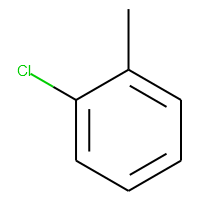
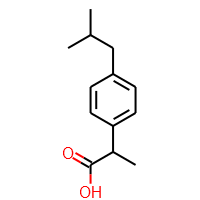
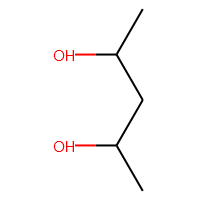
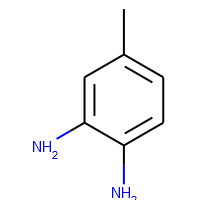
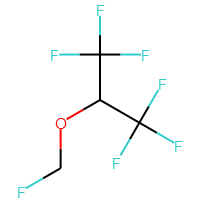
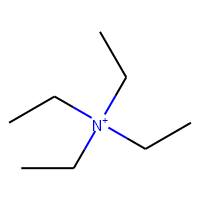
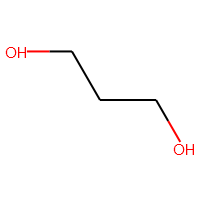
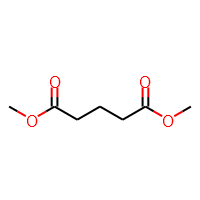
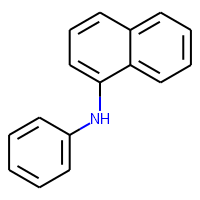
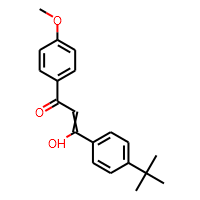
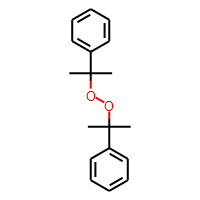
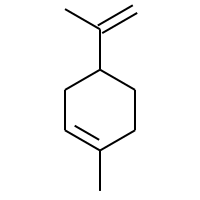
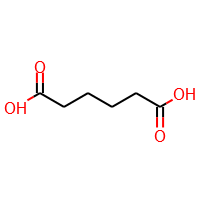
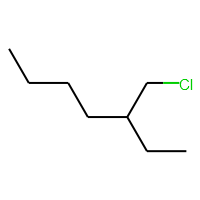
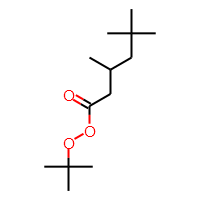
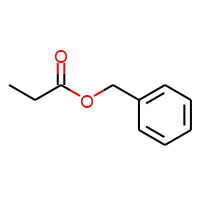
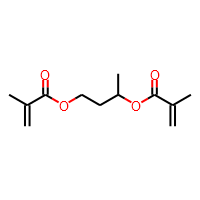
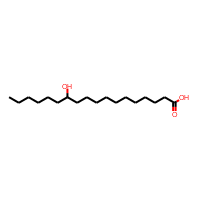
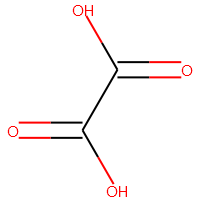
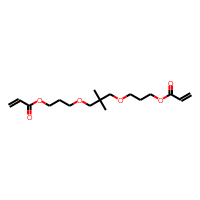
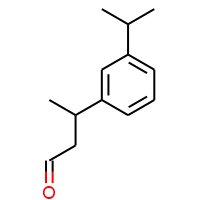
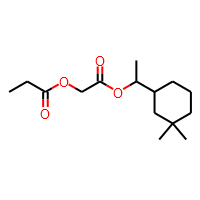
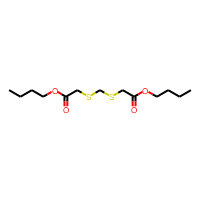
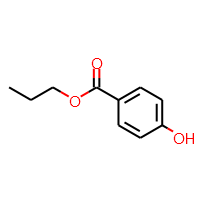
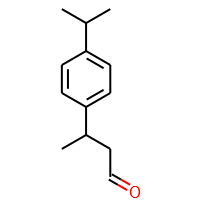
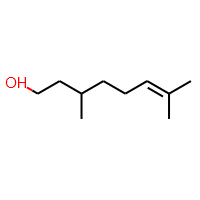
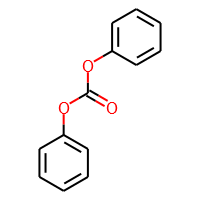
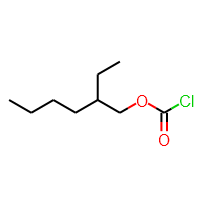
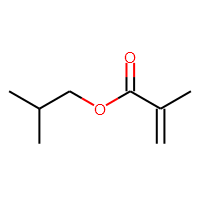
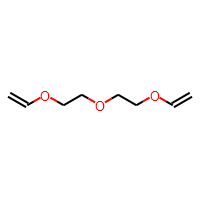
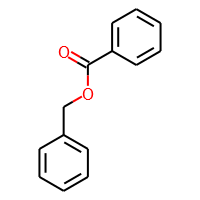
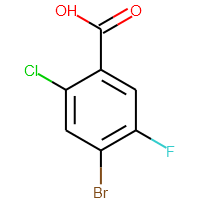
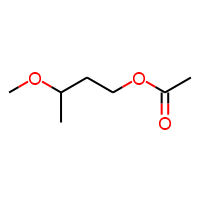
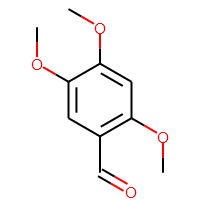
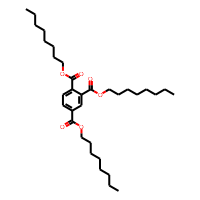
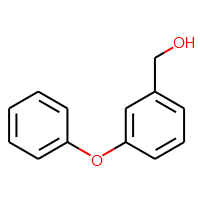
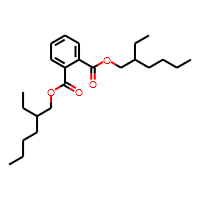
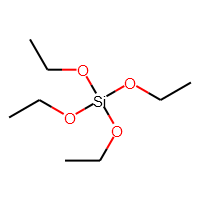
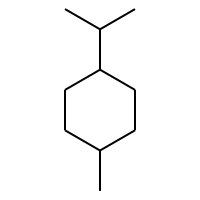
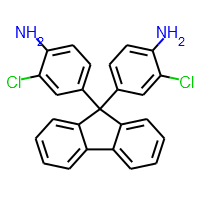
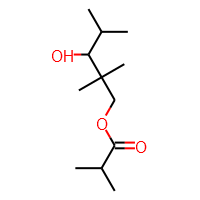
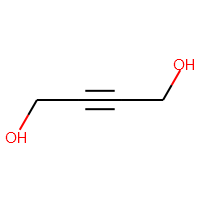
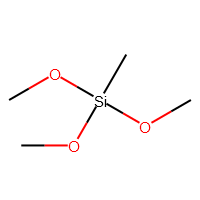
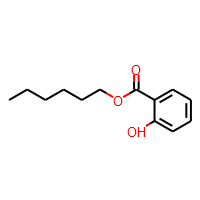
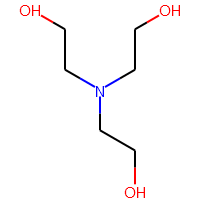
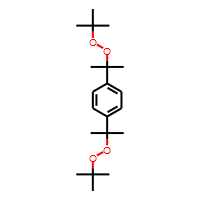
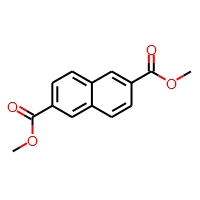
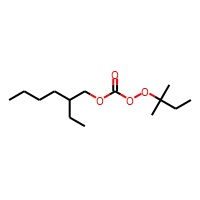
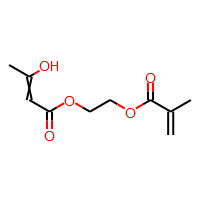
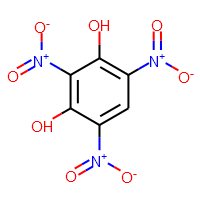
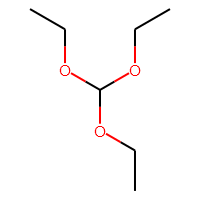
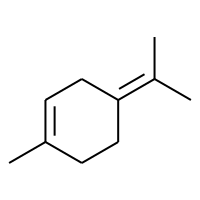
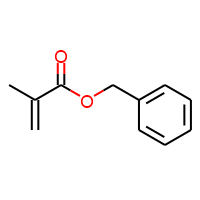
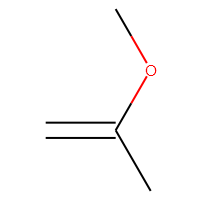
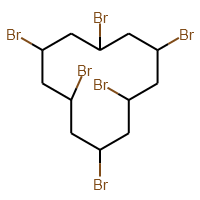
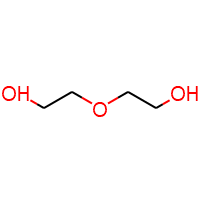
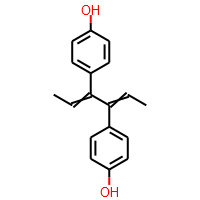
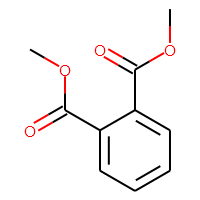
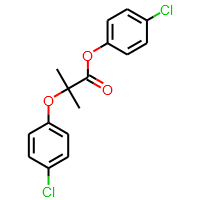
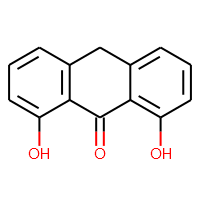
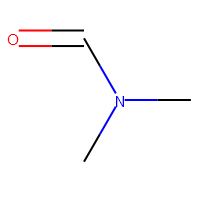
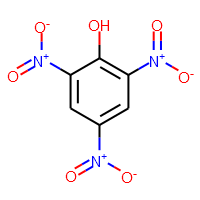
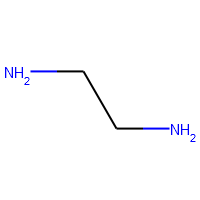
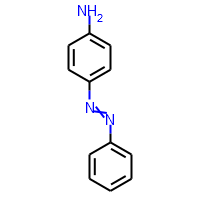
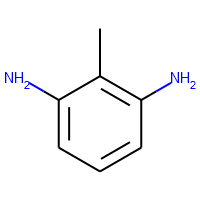
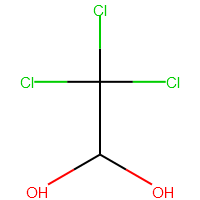
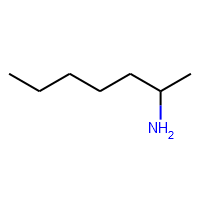
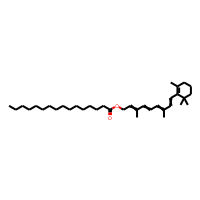
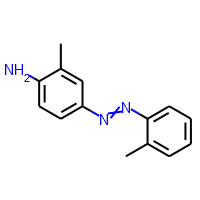
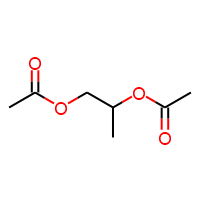
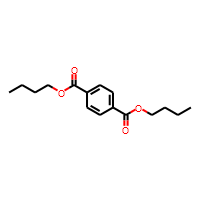
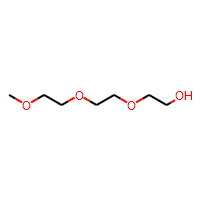
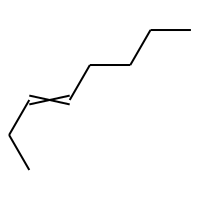
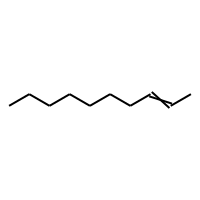
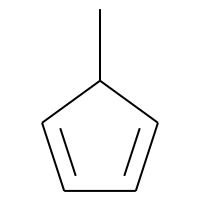
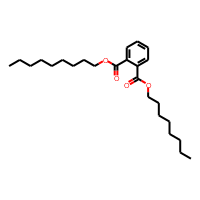
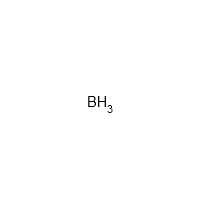
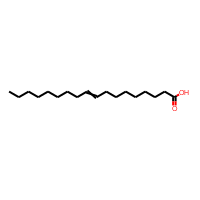
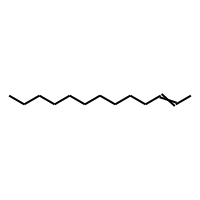
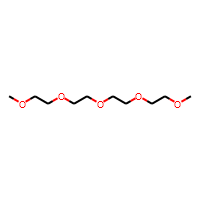
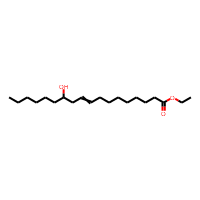
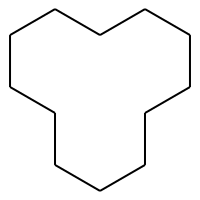
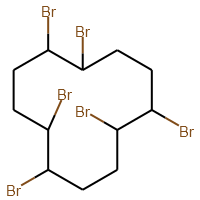
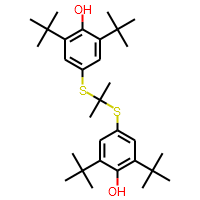
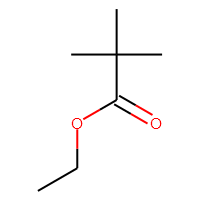
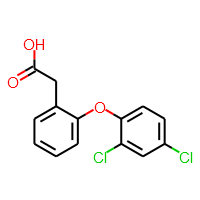
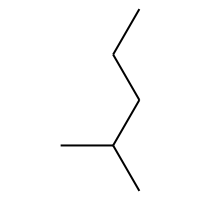
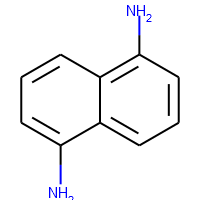
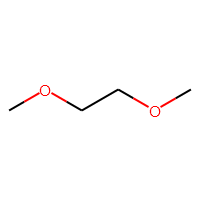
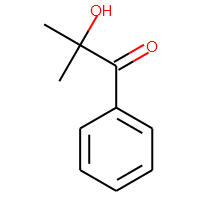
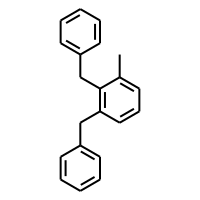
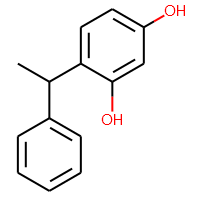
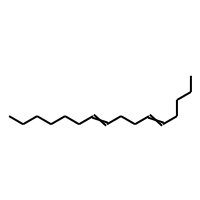
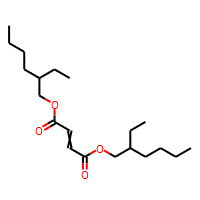
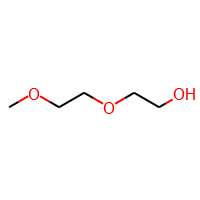
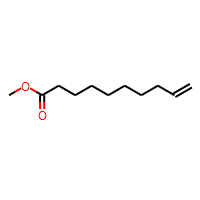
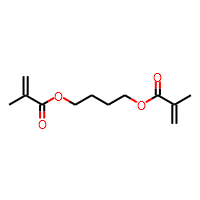
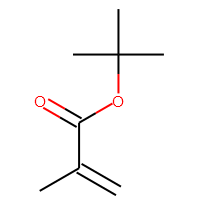
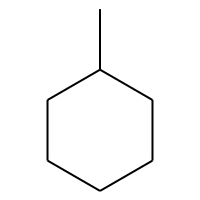
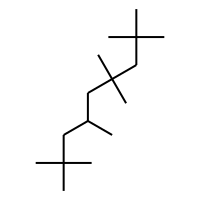

In [5]:
moldf= moldf.sort_values(['Outcome'], ascending=True)
moldf['RowID'] = moldf.index
moldf.head(100)

## 4. Definir a coluna a ser usada como variável dependente

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(moldf['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( moldf['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = moldf['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [1145 1146]
Total number of cpds             :  2291


{'0': 0, '1': 1}

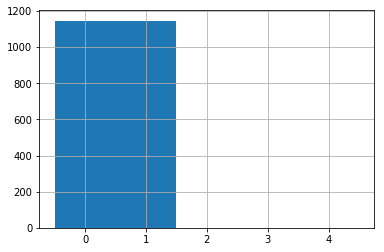

In [7]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

## 5. Descritor e Modelagem

In [8]:
nBits = 1024
radius=2
useFeatures= False

calcfp = lambda mol: GetMorganFingerprintAsBitVect(mol,nBits=nBits,radius=radius, useFeatures=useFeatures)
moldf['Descriptors'] = moldf.Mol.apply(calcfp)

y= np.int32((S))
x = np.array(list(moldf['Descriptors']))

In [9]:
############################################## Random Forest ##################################################
paramgrid = {"max_features": [x.shape[1] , x.shape[1] // 2,  x.shape[1] // 4,  x.shape[1] // 12,  x.shape[1] // 10, x.shape[1] // 7, x.shape[1] // 5, x.shape[1] // 3 ],
             "n_estimators": [ 10, 100, 300, 500], }


from sklearn.model_selection import RepeatedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV


ncores=1
verbose=1
seed = 24

np.random.seed(seed)

# Kappa Scorer 
kappa_scorer = metrics.make_scorer(quadratic_weighted_kappa, greater_is_better = True)



model = EvolutionaryAlgorithmSearchCV(estimator=RF(class_weight=None),
                                   params=paramgrid,
                                   scoring=kappa_scorer,
                                   cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   iid=True,
                                   refit=True,
                                   n_jobs=ncores)

model.fit(x, y)

# Get best model
best_model = model.best_estimator_

# Fit model with best parameters optimized for quadratic_weighted_kappa
best_model.fit(x,y)




Types [1, 1] and maxint [7, 3] detected
--- Evolve in 32 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.333515	0.272196	0.358656	0.0226174
1  	30    	0.347887	0.290506	0.358656	0.00971673
2  	24    	0.351972	0.33425 	0.358656	0.00530797
3  	25    	0.353906	0.33425 	0.358656	0.00544383
4  	36    	0.355993	0.342094	0.358656	0.00477401
5  	29    	0.358447	0.353447	0.358656	0.00102064
Best individual is: {'max_features': 256, 'n_estimators': 300}
with fitness: 0.3586555762163902


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=256, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 6. Avaliação Externa e Parametros Estatísticos

### 6.1 5-Fold Externo com todos os dados

k-nearest neighbour distance defined to the AD      :  13
AD Similarity limit      :  0.34620409854126427


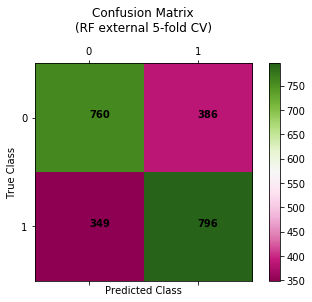

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.68
Area under the Curve (AUC): 0.68
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.68
Weighted Kappa:  0.36
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.7
Positive Predictive Value (PPV): 0.67
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.66
Negative Predictive Value (NPV): 0.69
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.67
Recall:  0.7
F1:  0.68
########################################
#        Applicability Domain          #
################################

In [10]:
 ypreds_folds_total_final,index_test_folds_final, training_labels_AD_final_conc,training_labels_pred_AD_final_conc, y_obs_folds, test_index_ad_final_conc, Dc,index_train_folds, index_test_folds, ypreds_folds, yproba_folds, k  = AD_scikitlearn(x,y,seed=seed, model_name= best_model)
run_statistics(y_obs_folds, ypreds_folds_total_final, label="RF external 5-fold CV", coverage=100)

### 6.2 5-Fold Externo somente com os dados no AD

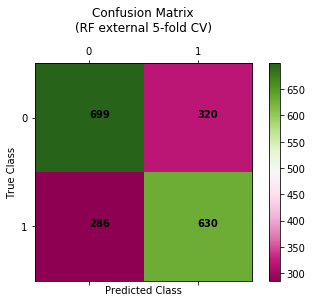

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.69
Area under the Curve (AUC): 0.69
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.69
Weighted Kappa:  0.37
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.69
Positive Predictive Value (PPV): 0.66
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.69
Negative Predictive Value (NPV): 0.71
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.66
Recall:  0.69
F1:  0.68
########################################
#        Applicability Domain          #
##############################

In [11]:
coverage=(((len(training_labels_AD_final_conc))*100)/(float(len(index_test_folds_final)*100))*100)
run_statistics(training_labels_AD_final_conc, training_labels_pred_AD_final_conc, label="RF external 5-fold CV", coverage=coverage)

# 7. Preparar os dados para salvar

### Atributos:

* molecules:
     `pandas.DataFrame()` com os descritores moleculares para o dataset* (usado na `similarity_table()`)
* descriptor:
    *`dict()` com informações do descritor utilizado (usado na `similarity_table()`)
        * function: função de calcular o descritor
        * info: `dict()` com os argumentos de entrada da função
        * name: nome do descritor
* models:
    * `list()` de `dict()` com os dados dos modelos:
        * model: modelo de predição do `scikit-learn`
        * name: nome do modelo
        * longname: descrição curta do modelo
        * descriptor: `dict()` com informações do descritor utilizado
            * function: função de calcular o descritor
            * info: `dict()` com os argumentos de entrada da função
            * name: nome do descritor
         fpDF: `pandas.DataFrame()` com os descritores moleculares para o dataset*
        * dataset: `pandas.DataFrame()` com as informações moleculares de validação do modelo
         applM: distribuição de similaridade do k*-vizinho mais próximo calculada para toda dataset
        * k: ordinal do vizinho mais próximo calculado para o dataset
        * dda: limite estabelecido para que a molécula esteja no domínio de aplicabilidade do modelo

### Métodos:

* `model_table()`:
    * Gera a tabela (`pandas.DataFrame()`) de resultados dos modelos
* `AD_table()`:
    * Gera a tabela (`pandas.DataFrame()`) de domínio de aplicabilidade dos modelos
* `similarity_table`:
    * Gera a tabela (`pandas.DataFrame()`) dos mapas de similaridade das `n` moléculas mais próximas.
    * Gera dados de similaridade que serão usados pela função `similarity_statistics()`
    
##  7.1 Gerando a tabela de dados com todas predições para cada fold

In [12]:
#Get all external Folds and save in Excel format

all_ext_Folds = pd.DataFrame()
for foldnum in range(1,5+1):
    for rep in range(1,5+1):
        final_frame = (len(moldf)-1) 
        fold_N= index_test_folds[foldnum-1]
        pred_N= ypreds_folds[foldnum-1]
        proba_N = yproba_folds[foldnum-1]
        
        tab = moldf.iloc[fold_N,:]
        tab['Prediction'] = pred_N
        tab['Confiability'] = proba_N
        tab['Fold'] = 'Fold {:d} extenal Repetition {:d}'.format(foldnum,rep)

        all_ext_Folds = all_ext_Folds.append(tab).reset_index(drop=True)


cols = ['ROMol','SMILES','Outcome','Prediction','Fold']

### melhorar ##
dX = dict()
[dX.update({i:[val]}) for i,val in enumerate(x)]
dfX = pd.DataFrame.from_dict(dX).T
dfX.columns=['FingerPrint']
dfX['SMILES'] = moldf['SMILES']

#########################

Dict_AD = {}
Dict_AD["FingerPrint"] = dfX
Dict_AD["Folds"] = all_ext_Folds
Dict_AD["k"] = k
Dict_AD["AD.distance.limit"] = Dc.mean()
Dict_AD["distance_AD"] = np.asarray(getNeighborsDitance(x, x, k))
Folds_true= Dict_AD["Folds"]
Folds_true = Folds_true.drop('Descriptors', 1)



###  7.1.1 Mostrando a tabela de dados com todas predições para cada fold (last one)

,CASRN,CpId,ID,InChIKey,Index,Outcome,Mol,SMILES,StandardizerResult,UN GHS,knn Distance,logP,RowID,Prediction,Confiability,Fold
0,496-72-0,1371,1371,"InChI=1S/C7H10N2/c1-5-2-3-6(8)7(9)4-5/h2-4H,8-9H2,1H3",1371,0,,Cc1ccc(N)c(N)c1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),NaN,3.0,1.15942,1535,1,54.666667,Fold 1 extenal Repetition 1
1,70356-09-1,920,920,XNEFYCZVKIDDMS-UHFFFAOYSA-N,920,0,,COc1ccc(C(=O)C=C(O)c2ccc(C(C)(C)C)cc2)cc1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,4.77450,1529,0,63.333333,Fold 1 extenal Repetition 1
2,1189-08-8,820,820,VDYWHVQKENANGY-UHFFFAOYSA-N,820,0,,C=C(C)C(=O)OCCC(C)OC(=O)C(=C)C,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,2.00360,1522,0,74.500000,Fold 1 extenal Repetition 1
3,84170-74-1,531,531,NQGDHQASSFDDLD-UHFFFAOYSA-N,531,0,,C=CC(=O)OCCCOCC(C)(C)COCCCOC(=O)C=C,Clear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,2.28440,1508,1,50.544444,Fold 1 extenal Repetition 1
4,94-13-3,633,633,QELSKZZBTMNZEB-UHFFFAOYSA-N,633,0,,CCCOC(=O)c1ccc(O)cc1,Dearomatize (ID: Dearomatize)\nClear Stereo (ID: ClearStereo)\nWedge Clean (ID: WedgeClean)\nMesomerize (ID: Mesomerize)\nTautomerize (ID: Tautomerize)\nAromatize (ID: Aromatize)\nAdd Explicit Hydrogens (ID: AddExplicitH)\nNeutralize (ID: Neutralize)\nClean 2D (ID: Clean2D),Non-irritant,3.0,1.95900,1512,0,86.000000,Fold 1 extenal Repetition 1

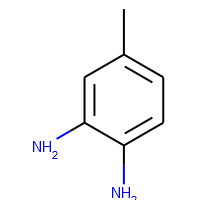
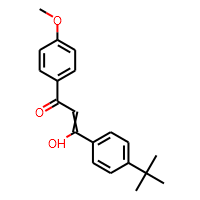
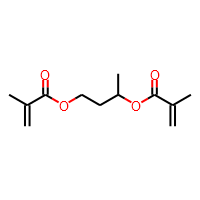
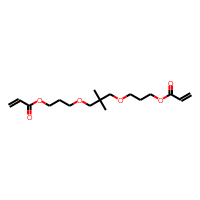
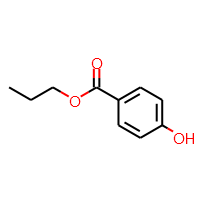

In [13]:
Folds_true.head()

In [14]:

newKeys = {'FingerPrint':'fpDF', 'Folds':'molDF',
        'k':'k', 'AD.distance.limit':'dda',
        'distance_AD':'applM'}

    # Renomeando as chaves
Dict_AD = {newKeys[key]:value for key,value in Dict_AD.items()}
    # Filtrando a tabela
Dict_AD['molDF'] = filter_table(Dict_AD['molDF'])

Dict_AD['molDF']['mol'] = list(map(Chem.MolFromSmiles,Dict_AD['molDF'].index))


##  7.2 Definir as categorias (resultado médias dos folds por molécula)

,Outcome,Prediction,Confiability,mol
SMILES,,,,
B,0,Irritant,94.666667,
B#N,0,Irritant,96.611111,
BrC(Br)C(Br)Br,1,Irritant,83.333333,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0,Irritant,80.666667,
BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,0,Irritant,78.666667,

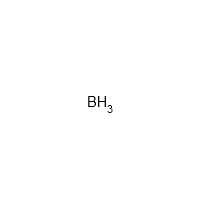
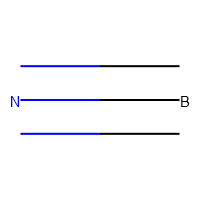
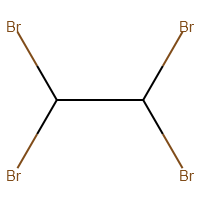
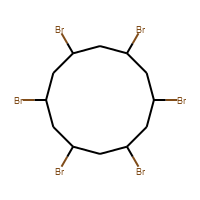
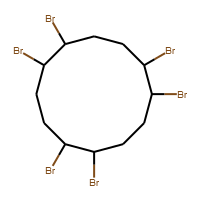

In [15]:
Dict_AD['molDF']['Prediction']=np.where(Dict_AD['molDF']['Prediction']>=0.6, 'Irritant', 'Non-Irritant')
Dict_AD['molDF'].head()

##  7.3 Mostras a distribuição da similaridade dos dados  AD

(array([  4.,  27., 196., 520., 652., 464., 218., 139.,  40.,  31.]),
 array([0.07142857, 0.15974026, 0.24805195, 0.33636364, 0.42467532,
        0.51298701, 0.6012987 , 0.68961039, 0.77792208, 0.86623377,
        0.95454545]),
 <a list of 10 Patch objects>)

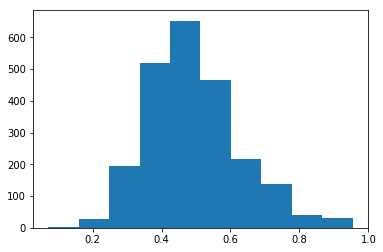

In [16]:
import matplotlib.pyplot as plt
plt.hist(Dict_AD['applM'])

#  8. Salvando modelo e os dados adicionais

In [17]:
from sklearn.externals import joblib
joblib.dump(best_model, 'model/Modelo_eye_irrit_morgan.pkl',compress=9)

['model/Modelo_eye_irrit_morgan.pkl']

In [18]:
import bz2
import pickle
import _pickle as cPickle
with bz2.BZ2File('model/Dados_adicionais_eye_irrit_morgan.pbz2', 'w') as f:
    pickle.dump(Dict_AD, f)
    